# LightFM -  hybrid matrix factorisation on MovieLens (Python, CPU)

This notebook explains the concept of a hybrid matrix factorisation based model for recommendation, it also outlines the steps to construct a pure matrix factorisation and a hybrid models using the [LightFM](https://github.com/lyst/lightfm) package. It also demonstrates how to extract both user and item affinity from a fitted hybrid model.

## 1. Hybrid matrix factorisation model

### 1.1 Background

In general, most recommendation models can be divided into two categories:
- Content based model,
- Collaborative filtering model.

The content-based model recommends based on similarity of the items and/or users using their description/metadata/profile. On the other hand, collaborative filtering model (discussion is limited to matrix factorisation approach in this notebook) computes the latent factors of the users and items. It works based on the assumption that if a group of people expressed similar opinions on an item, these peole would tend to have similar opinions on other items.

The choice between the two models is largely based on the data availability. For example, the collaborative filtering model is usually adopted and effective when sufficient ratings/feedbacks have been recorded for a group of users and items.

However, if there is a lack of ratings, content based model can be used provided that the metadata of the users and items are available. This is also the common approach to address the cold-start issues, where there are insufficient historical collaborative interactions available to model new users and/or items.

<!-- In addition, most collaborative filtering models only consume explicit ratings e.g. movie 

**NOTE** add stuff about implicit and explicit ratings -->

### 1.2 Hybrid matrix factorisation algorithm

In view of the above problems, there have been a number of proposals to address the cold-start issues by combining both content-based and collaborative filtering approaches.

In general, most hybrid approaches proposed different ways of assessing and/or combining the feature data in conjunction with the collaborative information.

### 1.3 LightFM package 

LightFM is a Python implementation of a hybrid recommendation algorithms for both implicit and explicit feedbacks.

It is a hybrid content-collaborative model which represents users and items as linear combinations of their content features’ latent factors. The model learns **embeddings or latent representations of the users and items in such a way that it encodes user preferences over items**. These representations produce scores for every item for a given user; items scored highly are more likely to be interesting to the user.

The user and item embeddings are estimated for every feature, and these features are then added together to be the final representations for users and items. 

For example, for user i, the model retrieves the i-th row of the feature matrix to find the features with non-zero weights. The embeddings for these features will then be added together to become the user representation e.g. if user 10 has weight 1 in the 5th column of the user feature matrix, and weight 3 in the 20th column, the user 10’s representation is the sum of embedding for the 5th and the 20th features multiplying their corresponding weights. The representation for each items is computed in the same approach. 



## 2. Movie recommender with LightFM using only explicit feedbacks

### 2.1 Import libraries

In [1]:
import sys
import os

import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scrapbook as sb
import itertools

import lightfm
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm import cross_validation
from lightfm.cross_validation import random_train_test_split

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k
from lightfm.data import Dataset


# Import LightFM's evaluation metrics
#from lightfm.evaluation import precision_at_k as lightfm_prec_at_k
#from lightfm.evaluation import recall_at_k as lightfm_recall_at_k
from lightfm.cross_validation import random_train_test_split

# Import repo's evaluation metrics
from recommenders.evaluation.python_evaluation import precision_at_k, recall_at_k

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.models.lightfm.lightfm_utils import (
    track_model_metrics, prepare_test_df, prepare_all_predictions,
    compare_metric, similar_users, similar_items)

print("System version: {}".format(sys.version))
print("LightFM version: {}".format(lightfm.__version__))

C:\Users\konst\AppData\Roaming\Python\Python39\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


System version: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
LightFM version: 1.16


### 2.2 Defining variables

In [2]:
# Select MovieLens data size
MOVIELENS_DATA_SIZE = '100k'

# default number of recommendations
K = 10
# percentage of data used for testing
TEST_PERCENTAGE = 0.3
# model learning rate
LEARNING_RATE = 0.25
# no of latent factors
NO_COMPONENTS = 20
# no of epochs to fit model
NO_EPOCHS = 20
# no of threads to fit model
NO_THREADS = 4
# regularisation for both user and item features
ITEM_ALPHA = 1e-6
USER_ALPHA = 1e-6

# seed for pseudonumber generations
SEED = 42

### 2.2 Retrieve data

In [3]:
data = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    genres_col='genre',
    header=["userID", "itemID", "rating"]
)
# quick look at the data
data.sample(5, random_state=SEED)

100%|████████████████████████████████████████████████████████████████████████████| 4.81k/4.81k [00:01<00:00, 2.51kKB/s]


,userID,itemID,rating,genre
75721,498,693,3.0,Drama
80184,642,542,5.0,Animation|Children's|Musical|Romance
19864,58,135,4.0,Drama|Mystery|Sci-Fi|Thriller
76699,495,674,3.0,Horror
92991,618,735,3.0,Drama


# 2.2.2 Retrieve data

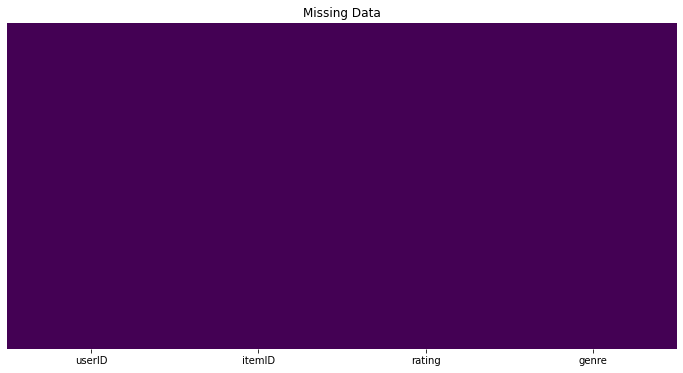

In [4]:
plt.figure(figsize=(12,6))
sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Data')
plt.show()


In [5]:
data.describe()

,userID,itemID,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


In [6]:
num_users = len(data['userID'].value_counts())
num_items = len(data['itemID'].value_counts())
print('Unique number of users in the dataset: {}'.format(num_users))
print('Unique number of movies in the dataset: {}'.format(num_items))

Unique number of users in the dataset: 943
Unique number of movies in the dataset: 1682


In [90]:
rating_count_df = pd.DataFrame(data.groupby(['rating']).size(), columns=['count'])
rating_count_df

,count
rating,
1.0,6110
2.0,11370
3.0,27145
4.0,34174
5.0,21201


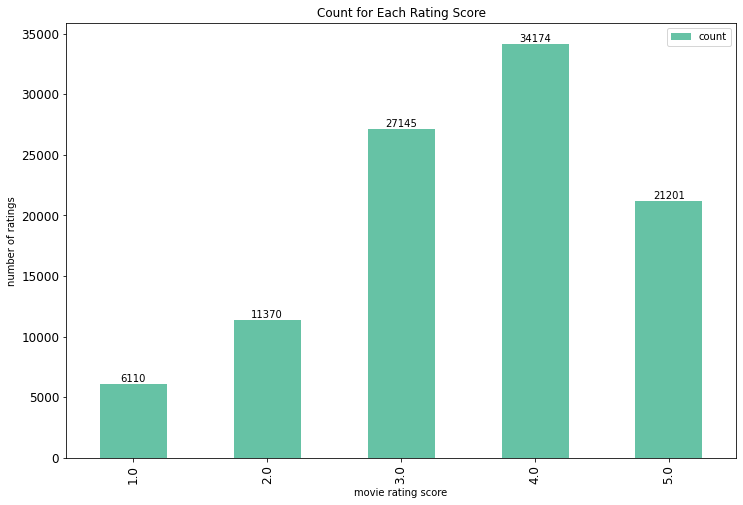

In [92]:
ax = rating_count_df.reset_index().rename(columns={'index': 'rating score'}).plot('rating','count','bar',
    figsize=(12, 8),
    title='Count for Each Rating Score',
    fontsize=12)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

# Add data labels above each bar
for index, value in enumerate(rating_count_df['count']):
    ax.text(index, value, str(value), ha='center', va='bottom')

plt.show()


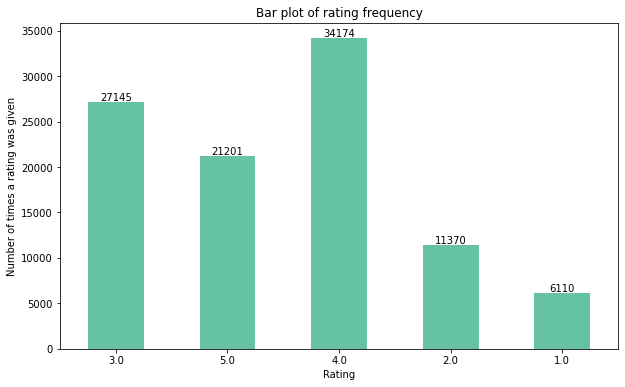

In [87]:
data['rating'].value_counts(sort=False).plot(kind='bar' ,figsize=(10,6), use_index=True, rot=0)
plt.title('Bar plot of rating frequency')
plt.xlabel('Rating')
plt.ylabel('Number of times a rating was given')

# Add data labels above each bar
label = list(data['rating'].value_counts(sort=False))
r4 = [1, 2, 3, 4, 5]
for i in range(len(r4)):
    plt.text(x=i, y=label[i], s=str(label[i]), ha='center', va='bottom')

plt.show()


In [10]:
total_count = num_items * num_users
zero_count = total_count-data.shape[0]
zero_count

1486126

In [11]:
# append counts of zero rating to df_ratings_cnt
rating_count_df = rating_count_df.append(
    pd.DataFrame({'count': zero_count}, index=[0.0]),
    verify_integrity=True,
).sort_index()
rating_count_df

C:\Users\konst\AppData\Local\Temp\ipykernel_7824\3047448168.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rating_count_df = rating_count_df.append(


,count
0.0,1486126
1.0,6110
2.0,11370
3.0,27145
4.0,34174
5.0,21201


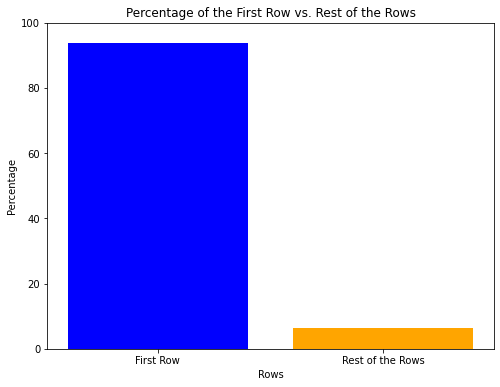

In [82]:

# Calculate the total count of ratings (excluding the first row)
total_count = rating_count_df['count'].sum()

# Calculate the percentage of the first row
first_row_percentage = (rating_count_df.loc[0.0, 'count'] / total_count) * 100

# Calculate the percentage of the rest of the rows
rest_rows_percentage = ((total_count - rating_count_df.loc[0.0, 'count']) / total_count) * 100

# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(['First Row', 'Rest of the Rows'], [first_row_percentage, rest_rows_percentage], color=['blue', 'orange'])
plt.xlabel('Rows')
plt.ylabel('Percentage')
plt.title('Percentage of the First Row vs. Rest of the Rows')
plt.ylim(0, 100)
plt.show()


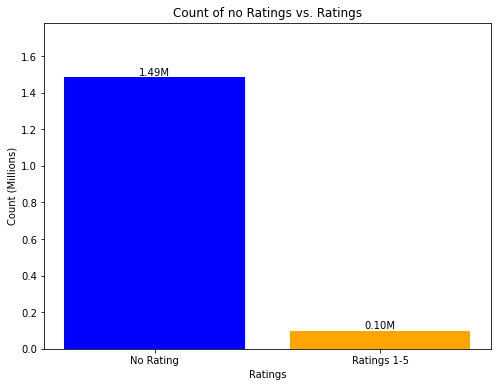

In [86]:


# Calculate the actual count of the first row (in millions)
first_row_count_millions = rating_count_df.loc[0.0, 'count'] / 1_000_000

# Calculate the actual count of the rest of the rows (in millions)
rest_rows_count_millions = (rating_count_df['count'].sum() - rating_count_df.loc[0.0, 'count']) / 1_000_000

# Create a bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(['No Rating', 'Ratings 1-5'], [first_row_count_millions, rest_rows_count_millions], color=['blue', 'orange'])
plt.xlabel('Ratings')
plt.ylabel('Count (Millions)')
plt.title('Count of no Ratings vs. Ratings')

# Add data labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}M', ha='center', va='bottom')

plt.ylim(0, max(first_row_count_millions, rest_rows_count_millions) * 1.2)
plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='rating'>

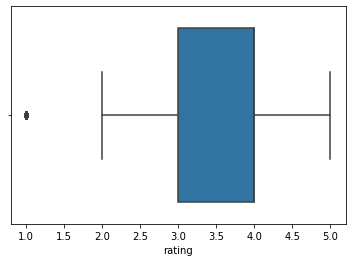

In [12]:
sns.boxplot(data['rating'])

In [13]:
# Unique count of things in the 'movies' dataset
unique_count = data.nunique()
print("Unique count of things in dataset:")
print(unique_count)


Unique count of things in dataset:
userID     943
itemID    1682
rating       5
genre      216
dtype: int64


In [14]:
item_feature_URLX = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.item'
columns = ['itemID','movie_name','release_date','n','imdb','itemID2','movie_name2','release_date2','n2','imdb2','itemID3','movie_name3','release_date3','n3','imdb3','itemID4','movie_name4','release_date4','n4','itemID5','movie_name5','release_date5','n5','imdb5',]
item_datax = pd.read_table(item_feature_URLX, sep='|', header=None, names=columns, encoding='latin-1')

# merging user feature with existing data
new_datax = data.merge(item_datax[['itemID','movie_name']], left_on='itemID', right_on='itemID')
# quick look at the merged data
new_datax.sample(5, random_state=SEED)

,userID,itemID,rating,genre,movie_name
75721,498,693,3.0,Drama,Casino (1995)
80184,642,542,5.0,Animation|Children's|Musical|Romance,Pocahontas (1995)
19864,58,135,4.0,Drama|Mystery|Sci-Fi|Thriller,2001: A Space Odyssey (1968)
76699,495,674,3.0,Horror,Cat People (1982)
92991,618,735,3.0,Drama,Philadelphia (1993)


In [15]:
movies_count_df = pd.DataFrame(new_datax.groupby(['movie_name']).size(), columns=['count'])
movies_count_df

,count
movie_name,
'Til There Was You (1997),9
1-900 (1994),5
101 Dalmatians (1996),109
12 Angry Men (1957),125
187 (1997),41
...,...
Young Guns II (1990),44
"Young Poisoner's Handbook, The (1995)",41
Zeus and Roxanne (1997),6


Text(0, 0.5, 'number of ratings')

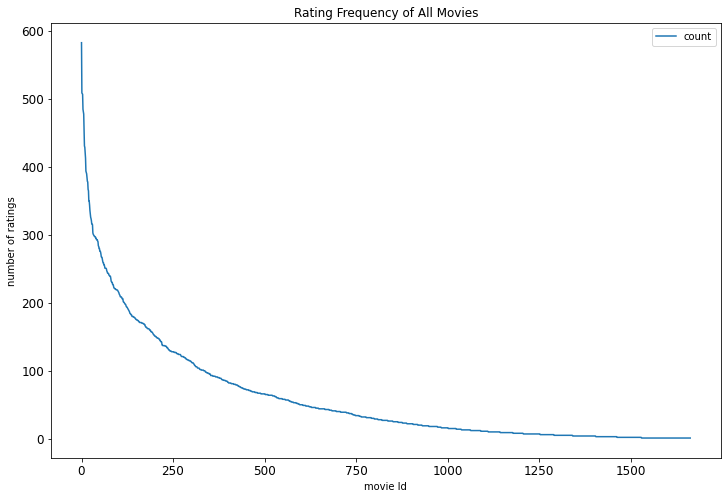

In [16]:
#Sparsity check
# plot rating frequency of all movies
ax = movies_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

In [17]:
# Calculate the count of ratings for each movie
ratings_count = new_datax.groupby('movie_name')['rating'].count()

# Sort the movies based on ratings count in descending order
top_movies = ratings_count.sort_values(ascending=False).head(10)

# Display the top movies with the most ratings
print("Top Movies with the Most Ratings:")
print(top_movies)
print()

Top Movies with the Most Ratings:
movie_name
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: rating, dtype: int64



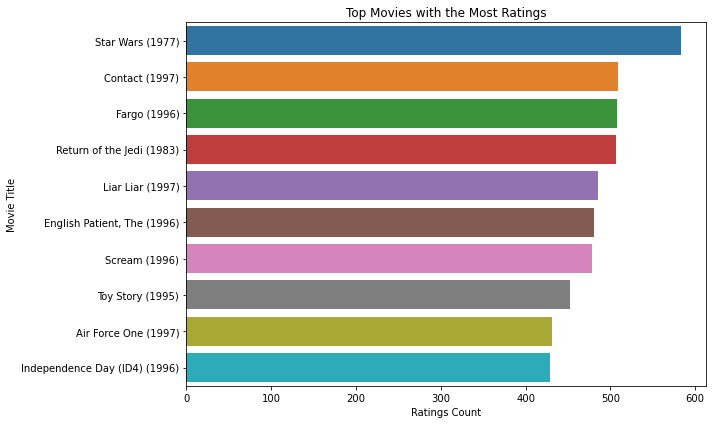

In [18]:
# Create a countplot to visualize the top movies with the most ratings
plt.figure(figsize=(10, 6))
sns.countplot(data=new_datax[new_datax['movie_name'].isin(top_movies.index)], y='movie_name', order=top_movies.index)
plt.title('Top Movies with the Most Ratings')
plt.xlabel('Ratings Count')
plt.ylabel('Movie Title')
plt.tight_layout()
plt.show()

In [19]:
bottom_movies = ratings_count.sort_values(ascending=True).head(10)


In [20]:
# Finding the average rating for movie and the number of ratings for each movie
avg_movie_rating = pd.DataFrame(new_datax.groupby('itemID')['rating'].agg(['mean','count']))
avg_movie_rating['movieId']= avg_movie_rating.index
avg_movie_rating['mean'] = avg_movie_rating['mean'].round(2)

In [21]:
avg_movie_rating.describe()

,mean,count,movieId
count,1682.000000,1682.000000,1682.000000
mean,3.076070,59.453032,841.500000
std,0.781699,80.383846,485.695893
min,1.000000,1.000000,1.000000
25%,2.660000,6.000000,421.250000
50%,3.160000,27.000000,841.500000
75%,3.650000,80.000000,1261.750000
max,5.000000,583.000000,1682.000000


In [22]:
#Get the average movie rating across all movies 
avg_rating_all=new_datax['rating'].mean()
avg_rating_all
#set a minimum threshold for number of reviews that the movie has to have
min_reviews=30
min_reviews
movie_score = avg_movie_rating.loc[avg_movie_rating['count']>min_reviews]
movie_score.head()

,mean,count,movieId
itemID,,,
1,3.88,452,1
2,3.21,131,2
3,3.03,90,3
4,3.55,209,4
5,3.30,86,5


In [23]:
num_items = len(movie_score['movieId'].value_counts())
print('Unique number of movies in the dataset: {}'.format(num_items))

Unique number of movies in the dataset: 798


In [24]:
new_datax['mean_rating'] = new_datax['itemID'].map(avg_movie_rating['mean'])
new_datax['rating_count'] = new_datax['itemID'].map(avg_movie_rating['count'])

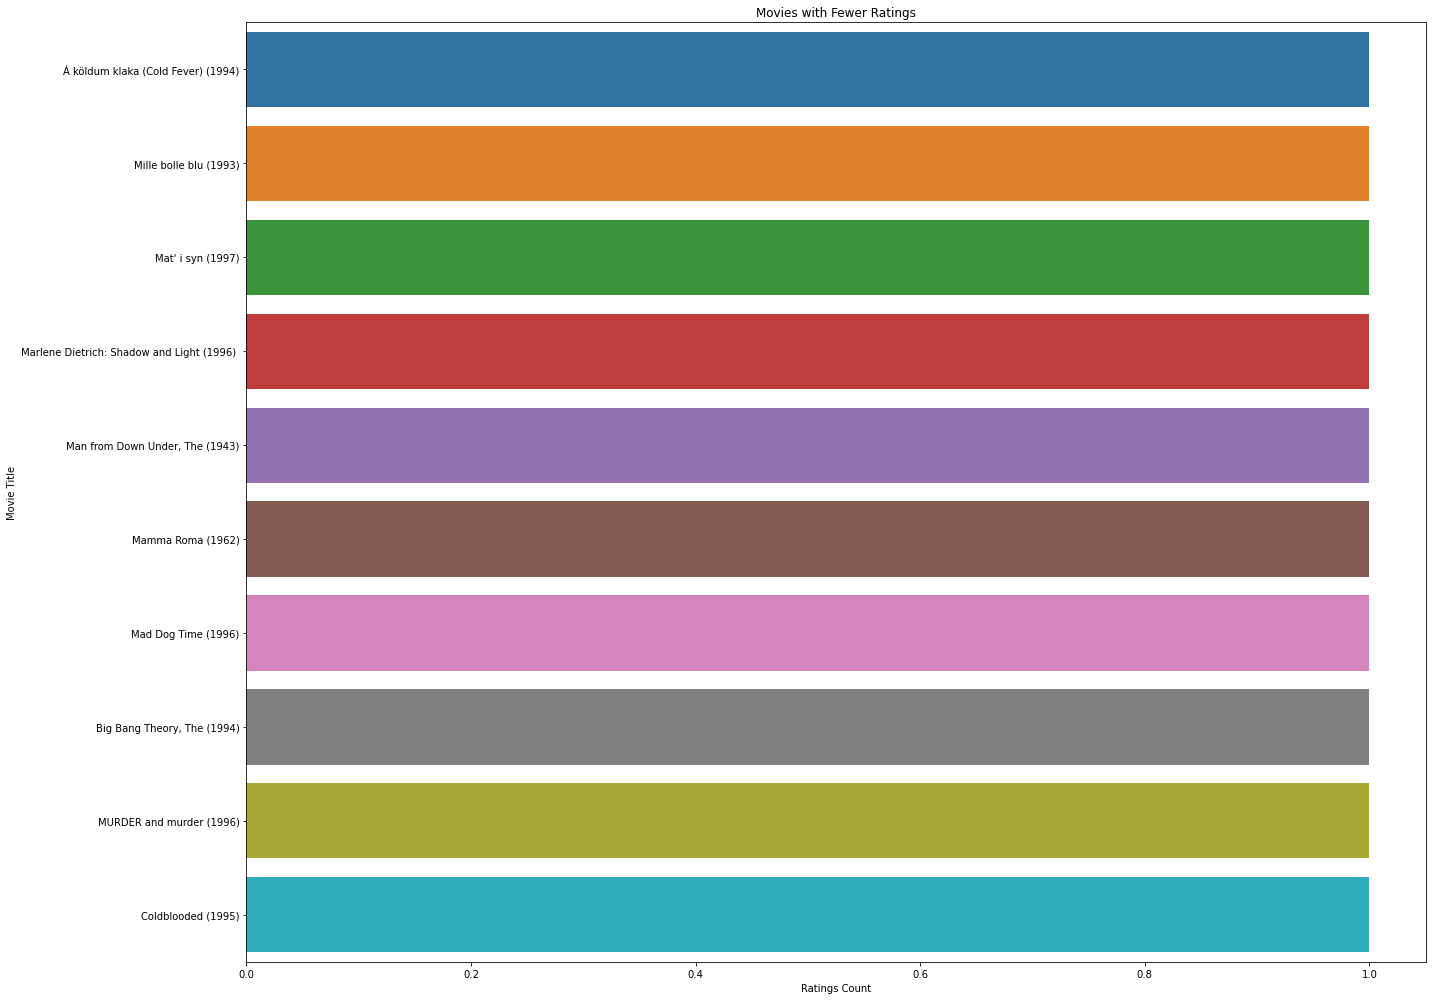

In [25]:
# Create a countplot to visualize the movies with fewer ratings
plt.figure(figsize=(20, 14))
sns.countplot(data=new_datax[new_datax['movie_name'].isin(bottom_movies.index)], y='movie_name', order=bottom_movies.index)
plt.title('Movies with Fewer Ratings')
plt.xlabel('Ratings Count')
plt.ylabel('Movie Title')
plt.tight_layout()
plt.show()

### 2.3 Prepare data

Before fitting the LightFM model, we need to create an instance of `Dataset` which holds the interaction matrix.

In [26]:
dataset = Dataset()

The `fit` method creates the user/item id mappings.

In [27]:
dataset.fit(users=data['userID'], 
            items=data['itemID'])

# quick check to determine the number of unique users and items in the data
num_users, num_topics = dataset.interactions_shape()
print(f'Num users: {num_users}, num_topics: {num_topics}.')

Num users: 943, num_topics: 1682.


Next is to build the interaction matrix. The `build_interactions` method returns 2 COO sparse matrices, namely the `interactions` and `weights` matrices.

In [28]:
(interactions, weights) = dataset.build_interactions(data.iloc[:, 0:3].values)

LightFM works slightly differently compared to other packages as it expects the train and test sets to have same dimension. Therefore the conventional train test split will not work.

The package has included the `cross_validation.random_train_test_split` method to split the interaction data and splits it into two disjoint training and test sets. 

However, note that **it does not validate the interactions in the test set to guarantee all items and users have historical interactions in the training set**. Therefore this may result into a partial cold-start problem in the test set.

In [29]:
train_interactions, test_interactions = cross_validation.random_train_test_split(
    interactions, test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEED))

Double check the size of both the train and test sets.

In [30]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (943, 1682)
Shape of test interactions: (943, 1682)


### 2.4 Fit the LightFM model

We will run through iterations of hyperparameters to look for the possible best ones.
Because we can't iterate through all of them we will take same basic ones keeping also the default parameters in a
possibility that they might perform better later when we will compare the models

In [31]:

from lightfm.evaluation import precision_at_k, recall_at_k


# Define the hyperparameters to tune
num_components = [10, 20, 30]
learning_rates = [0.05, 0.1, 0.25]
item_alphas = [0.000001, 0.0005, 0.001]
user_alphas = [0.000001, 0.0005, 0.001]

# Initialize variables to store the best hyperparameters and evaluation metrics
best_precision = 0.0
best_recall = 0.0
best_hyperparameters = {}

# Split the data into train and test sets
train_interactions, test_interactions = random_train_test_split(interactions, test_percentage=0.3, random_state=42)

# Perform hyperparameter search
for num_component in num_components:
    for learning_rate in learning_rates:
        for item_alpha in item_alphas:
            for user_alpha in user_alphas:
                # Create the LightFM model with the current hyperparameters
                model = LightFM(
                    loss='warp',
                    no_components=num_component,
                    learning_rate=learning_rate,
                    item_alpha=item_alpha,
                    user_alpha=user_alpha,
                    random_state=42
                )
                
                # Fit the model to the training data
                model.fit(train_interactions, epochs=20, num_threads=4)
              
                # Evaluate the model on the test data
                precision = precision_at_k(model, test_interactions, train_interactions=train_interactions, k=5).mean()
                recall = recall_at_k(model, test_interactions, train_interactions=train_interactions, k=5).mean()
                
                # Check if the current hyperparameters result in better performance
                if precision > best_precision:
                    best_precision = precision
                    best_recall = recall
                    best_hyperparameters = {
                        'num_components': num_component,
                        'learning_rate': learning_rate,
                        'item_alpha': item_alpha,
                        'user_alpha': user_alpha
                    }

# Print the best hyperparameters and evaluation metrics
print('Best Hyperparameters:')
print(best_hyperparameters)
print('Precision@5:', best_precision)
print('Recall@5:', best_recall)


Best Hyperparameters:
{'num_components': 30, 'learning_rate': 0.1, 'item_alpha': 0.001, 'user_alpha': 0.001}
Precision@5: 0.5160128
Recall@5: 0.12697471734030844


In [32]:
print(f"Shape of train interactions: {train_interactions.shape}")
print(f"Shape of test interactions: {test_interactions.shape}")

Shape of train interactions: (943, 1682)
Shape of test interactions: (943, 1682)


In this notebook, the LightFM model will be using the weighted Approximate-Rank Pairwise (WARP) as the loss. Further explanation on the topic can be found [here](https://making.lyst.com/lightfm/docs/examples/warp_loss.html#learning-to-rank-using-the-warp-loss).


In general, it maximises the rank of positive examples by repeatedly sampling negative examples until a rank violation has been located. This approach is recommended when only positive interactions are present.

In [33]:
model1 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE,                 
                 random_state=np.random.RandomState(SEED))

The LightFM model can be fitted with the following code:

In [34]:
model1.fit(interactions=train_interactions,
          epochs=NO_EPOCHS);

### 2.5 Prepare model evaluation data

Before we can evaluate the fitted model and to get the data into a format which is compatible with the existing evaluation methods within this repo, the data needs to be massaged slightly.

First the train/test indices need to be extracted from the `lightfm.cross_validation` method as follows:

In [35]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions.row, interactions.col, interactions.data, 
    random_state=np.random.RandomState(SEED))

cutoff = int((1.0 - TEST_PERCENTAGE) * len(uids))
test_idx = slice(cutoff, None)

Then the the mapping between internal and external representation of the user and item are extracted as follows:

In [36]:
uid_map, ufeature_map, iid_map, ifeature_map = dataset.mapping()

Once the train/test indices and mapping are ready, the test dataframe can be constructed as follows:

In [37]:
with Timer() as test_time:
    test_df = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  
time_reco1 = test_time.interval

Took 2.2 seconds for prepare and predict test data.


And samples of the test dataframe:

In [38]:
test_df.sample(5, random_state=SEED)

,userID,itemID,rating
2308,160,447,4.0
22404,841,326,4.0
23397,323,23,5.0
25058,907,268,4.0
2664,293,94,2.0


In addition, the predictions of all unseen user-item pairs (e.g. removing those seen in the training data) can be prepared as follows:

In [39]:
with Timer() as test_time:
    all_predictions = prepare_all_predictions(data, uid_map, iid_map, 
                                              interactions=train_interactions,
                                              model=model1, 
                                              num_threads=NO_THREADS)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")
time_reco2 = test_time.interval

Took 427.2 seconds for prepare and predict all data.


Samples of the `all_predictions` dataframe:

In [40]:
all_predictions.sample(5, random_state=SEED)

,userID,itemID,prediction
255839,346,1283,-22.208010
732982,373,793,-44.887943
261027,362,200,-0.088179
429205,896,1012,-26.121321
662274,142,548,-0.808844


Note that the **raw prediction values from the LightFM model are for ranking purposes only**, they should not be used directly. The magnitude and sign of these values do not have any specific interpretation.

### 2.6 Model evaluation

Once the evaluation data are ready, they can be passed into to the repo's evaluation methods as follows. The performance of the model will be tracked using both Precision@K and Recall@K.

In addition, the results have also being compared with those computed from LightFM's own evaluation methods to ensure accuracy.

In [41]:
with Timer() as test_time:
    eval_precision = precision_at_k(model=model1, test_interactions=test_interactions, train_interactions=train_interactions, k=K).mean()
    eval_recall = recall_at_k(model=model1, test_interactions=test_interactions, train_interactions=train_interactions, k=K).mean()
time_reco3 = test_time.interval

with Timer() as test_time:
    eval_precision_lfm = precision_at_k(model=model1, test_interactions=test_interactions, train_interactions=train_interactions, k=K).mean()
    eval_recall_lfm = recall_at_k(model=model1, test_interactions=test_interactions, train_interactions=train_interactions, k=K).mean()
time_lfm = test_time.interval

print(
    "------ Using Repo's evaluation methods ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    "\n------ Using LightFM evaluation methods ------",
    f"Precision@K:\t{eval_precision_lfm:.6f}",
    f"Recall@K:\t{eval_recall_lfm:.6f}",
    sep='\n')




------ Using Repo's evaluation methods ------
Precision@K:	0.165748
Recall@K:	0.046015

------ Using LightFM evaluation methods ------
Precision@K:	0.165748
Recall@K:	0.046015


## 3. Movie recommender with LightFM using explicit feedbacks and additional item and user features

As the LightFM was designed to incorporates both user and item metadata, the model can be extended to include additional features such as movie genres and user occupations.

### 3.1 Extract and prepare movie genres

In this notebook, the movie's genres will be used as the item metadata. As the genres have already been loaded during the initial data import, it can be processed directly as follows:

In [42]:
# split the genre based on the separator
movie_genre = [x.split('|') for x in data['genre']]

In [43]:
# retrieve the all the unique genres in the data
all_movie_genre = sorted(list(set(itertools.chain.from_iterable(movie_genre))))
# quick look at the all the genres within the data
all_movie_genre

['Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western',
 'unknown']

### 3.2 Retrieve and prepare movie genres

Further user features can be included as part of the model fitting process. In this notebook, **only the occupation of each user will be included** but the feature list can be extended easily.


#### 3.2.1 Retrieve and merge data

The user features can be retrieved directly from the grouplens website and merged with the existing data as follows:

In [44]:
user_feature_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.user'
columns = ['userID','age','gender','occupation','zipcode']
user_data = pd.read_table(user_feature_URL, sep='|', header=None, names=columns)

# merging user feature with existing data
new_data = data.merge(user_data[['userID','occupation']], left_on='userID', right_on='userID')
# quick look at the merged data
new_data.sample(5, random_state=SEED)

,userID,itemID,rating,genre,occupation
75721,455,402,4.0,Comedy|Romance|Thriller,administrator
80184,746,161,3.0,Action|Romance,engineer
19864,268,12,4.0,Crime|Thriller,engineer
76699,600,1004,4.0,Drama|Western,programmer
92991,396,125,3.0,Drama|Romance,engineer


In [45]:
data.sample(5, random_state=SEED)

,userID,itemID,rating,genre
75721,498,693,3.0,Drama
80184,642,542,5.0,Animation|Children's|Musical|Romance
19864,58,135,4.0,Drama|Mystery|Sci-Fi|Thriller
76699,495,674,3.0,Horror
92991,618,735,3.0,Drama


In [46]:
#new_data.drop(columns=['occupation_x', 'occupation_y'], inplace=True)


In [47]:
new_data.sample(5, random_state=SEED)

,userID,itemID,rating,genre,occupation
75721,455,402,4.0,Comedy|Romance|Thriller,administrator
80184,746,161,3.0,Action|Romance,engineer
19864,268,12,4.0,Crime|Thriller,engineer
76699,600,1004,4.0,Drama|Western,programmer
92991,396,125,3.0,Drama|Romance,engineer


In [48]:
item_feature_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k/u.item'
columns = ['itemID','movie_name','release_date','n','imdb','itemID2','movie_name2','release_date2','n2','imdb2','itemID3','movie_name3','release_date3','n3','imdb3','itemID4','movie_name4','release_date4','n4','itemID5','movie_name5','release_date5','n5','imdb5',]
item_data = pd.read_table(item_feature_URL, sep='|', header=None, names=columns, encoding='latin-1')

# merging user feature with existing data
new_data = new_data.merge(item_data[['itemID','release_date']], left_on='itemID', right_on='itemID')
# quick look at the merged data
new_data.sample(5, random_state=SEED)

,userID,itemID,rating,genre,occupation,release_date
75721,687,879,3.0,Action|Thriller|War,healthcare,01-Jan-1997
80184,262,252,3.0,Action|Adventure|Sci-Fi|Thriller,student,23-May-1997
19864,927,300,5.0,Action|Thriller,programmer,01-Jan-1997
76699,932,189,5.0,Animation|Comedy,educator,01-Jan-1992
92991,22,386,3.0,Comedy,writer,01-Jan-1993


In [49]:
item_data.head()

,itemID,movie_name,release_date,n,imdb,itemID2,movie_name2,release_date2,n2,imdb2,...,imdb3,itemID4,movie_name4,release_date4,n4,itemID5,movie_name5,release_date5,n5,imdb5
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### 3.2.2 Extract and prepare user occupations

In [50]:
# retrieve all the unique occupations in the data
all_occupations = sorted(list(set(new_data['occupation'])))

### 3.3 Prepare data and features

Similar to the previous model, the data is required to be converted into a `Dataset` instance and then create a user/item id mapping with the `fit` method.

In [51]:
dataset2 = Dataset()
dataset2.fit(data['userID'], 
            data['itemID'], 
            item_features=all_movie_genre,
            user_features=all_occupations)

The movie genres are then converted into a item feature matrix using the `build_item_features` method as follows:

In [52]:
item_features = dataset2.build_item_features((x, y) for x,y in zip(data.itemID, movie_genre))

The user occupations are then converted into an user feature matrix using the `build_user_features` method as follows:

In [53]:
user_features = dataset2.build_user_features((x, [y]) for x,y in zip(new_data.userID, new_data['occupation']))

Once the item and user features matrices have been completed, the next steps are similar as before, which is to build the interaction matrix and split the interactions into train and test sets as follows:

In [54]:
interactions2, weights2 = dataset2.build_interactions(data.iloc[:, 0:3].values)

train_interactions2, test_interactions2 = cross_validation.random_train_test_split(
    interactions2, 
    test_percentage=TEST_PERCENTAGE,
    random_state=np.random.RandomState(SEED)
)

### 3.3 Fit the LightFM model with additional user and item features

The parameters of the second model will be similar to the first model to facilitates comparison.

The model performance at each epoch is also tracked by the same metrics as before.

In [55]:
model2 = LightFM(loss='warp', no_components=NO_COMPONENTS, 
                 learning_rate=LEARNING_RATE, 
                 item_alpha=ITEM_ALPHA,
                 user_alpha=USER_ALPHA,
                 random_state=np.random.RandomState(SEED)
                )

The LightFM model can then be fitted:

In [56]:
model2.fit(interactions=train_interactions2,
           user_features=user_features,
           item_features=item_features,
           epochs=NO_EPOCHS
           )

### 3.4 Prepare model evaluation data

Similar to the previous model, the evaluation data needs to be prepared in order to get them into a format consumable with this repo's evaluation methods.

Firstly the train/test indices and id mappings are extracted using the new interations matrix as follows:

In [57]:
uids, iids, interaction_data = cross_validation._shuffle(
    interactions2.row, 
    interactions2.col, 
    interactions2.data, 
    random_state=np.random.RandomState(SEED)
)

uid_map, ufeature_map, iid_map, ifeature_map = dataset2.mapping()

The test dataframe is then constructed as follows:

In [58]:
with Timer() as test_time:
    test_df2 = prepare_test_df(test_idx, uids, iids, uid_map, iid_map, weights2)
print(f"Took {test_time.interval:.1f} seconds for prepare and predict test data.")  

Took 2.3 seconds for prepare and predict test data.


The predictions of all unseen user-item pairs can be prepared as follows:

In [59]:
with Timer() as test_time:
    all_predictions2 = prepare_all_predictions(data, uid_map, iid_map, 
                                              interactions=train_interactions2,
                                               user_features=user_features,
                                               item_features=item_features,
                                               model=model2,
                                               num_threads=NO_THREADS)

print(f"Took {test_time.interval:.1f} seconds for prepare and predict all data.")

Took 225.1 seconds for prepare and predict all data.


### 3.5 Model evaluation and comparison

The predictive performance of the new model can be computed and compared with the previous model (which used only the explicit rating) as follows:

In [60]:
eval_precision2 = precision_at_k(
    model=model2,
    test_interactions=test_interactions2,
    train_interactions=train_interactions2,
    user_features=user_features,
    item_features=item_features,
    k=K
)
eval_recall2 = recall_at_k(
    model=model2,
    test_interactions=test_interactions2,
    train_interactions=train_interactions2,
    user_features=user_features,
    item_features=item_features,
    k=K
)

print(
    "------ Using only explicit ratings ------",
    f"Precision@K:\t{eval_precision:.6f}",
    f"Recall@K:\t{eval_recall:.6f}",
    "\n------ Using both implicit and explicit ratings ------",
    f"Precision@K:\t{eval_precision2.mean():.6f}",
    f"Recall@K:\t{eval_recall2.mean():.6f}",
    sep='\n'
)

------ Using only explicit ratings ------
Precision@K:	0.165748
Recall@K:	0.046015

------ Using both implicit and explicit ratings ------
Precision@K:	0.171686
Recall@K:	0.051559


The new model which used both implicit and explicit data performed consistently better than the previous model which used only the explicit data, thus highlighting the benefits of including such additional features to the model.

### 3.6 Evaluation metrics comparison

Note that the evaluation approaches here are solely for demonstration purposes only.

If the reader were using the LightFM package and/or its models, the LightFM's built-in evaluation methods are much more efficient and are the recommended approach for production usage as they are designed and optimised to work with the package. If the reader wants to compare LigthFM with other algorithms in Recommenders repository, it is better to use the evaluation tools in Recommenders.

As a comparison, the times recorded to evaluate model1 are shown as follows:

In [61]:
print(
    "------ Using Repo's evaluation methods ------",
    f"Time [sec]:\t{(time_reco1+time_reco2+time_reco3):.1f}",
    "\n------ Using LightFM evaluation methods ------",
    f"Time [sec]:\t{time_lfm:.1f}",
    sep='\n')

------ Using Repo's evaluation methods ------
Time [sec]:	429.8

------ Using LightFM evaluation methods ------
Time [sec]:	0.4


Let's try some additional parameters so that our model may perform better

In [62]:
# Define the hyperparameters to tune
num_components = [10, 20, 30]
learning_rates = [0.05, 0.1, 0.25]
item_alphas = [0.000001, 0.0005, 0.001]
user_alphas = [0.000001, 0.0005, 0.001]

# Initialize variables to store the best hyperparameters and evaluation metrics
best_precision = 0.0
best_recall = 0.0
best_hyperparameters = {}

# Split the data into train and test sets
train_interactions2, test_interactions2 = random_train_test_split(
    interactions2, test_percentage=0.3, random_state=np.random.RandomState(SEED) #TEST_PERCENTAGE
)

# Perform hyperparameter search
for num_component, learning_rate, item_alpha, user_alpha in itertools.product(
    num_components, learning_rates, item_alphas, user_alphas
):
    # Create the LightFM model with the current hyperparameters
    model4 = LightFM(
        loss='warp',
        no_components=num_component,
        learning_rate=learning_rate,
        item_alpha=item_alpha,
        user_alpha=user_alpha,
        random_state=np.random.RandomState(SEED)
    )

    # Fit the model to the training data
    model4.fit(
        interactions=train_interactions2,
        user_features=user_features,
        item_features=item_features,
        epochs=NO_EPOCHS
    )

    # Evaluate the model on the test data
    precision = precision_at_k(
        model=model4,
        test_interactions=test_interactions2,
        train_interactions=train_interactions2,
        user_features=user_features,
        item_features=item_features,
        k=K
    ).mean()
    recall = recall_at_k(
        model=model4,
        test_interactions=test_interactions2,
        train_interactions=train_interactions2,
        user_features=user_features,
        item_features=item_features,
        k=K
    ).mean()

    # Check if the current hyperparameters result in better performance
    if precision > best_precision:
        best_precision = precision
        best_recall = recall
        best_hyperparameters = {
            'num_components': num_component,
            'learning_rate': learning_rate,
            'item_alpha': item_alpha,
            'user_alpha': user_alpha
        }

# Print the best hyperparameters and evaluation metrics
print('Best Hyperparameters:')
print(best_hyperparameters)
print('Precision@K:', best_precision)
print('Recall@K:', best_recall)

Best Hyperparameters:
{'num_components': 20, 'learning_rate': 0.25, 'item_alpha': 1e-06, 'user_alpha': 1e-06}
Precision@K: 0.1716861
Recall@K: 0.05155853854294918


## 4. Evaluate model fitting process

In addition to the inclusion of both implicit and explicit data, the model fitting process can also be monitored in order to determine whether the model is being trained properly. 

This notebook also includes a `track_model_metrics` method which plots the model's metrics e.g. Precision@K and Recall@K as model fitting progresses.

For the first 2 models (using only explicit data) with different tuning parameters to compare.The fitting progress is shown as follows:

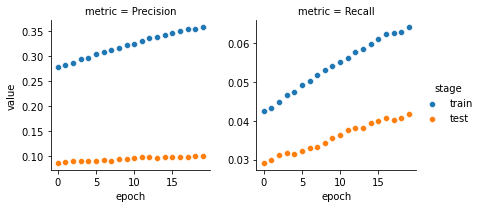

In [63]:
output1, _ = track_model_metrics(model=model1, 
                                 train_interactions=train_interactions, 
                                 test_interactions=test_interactions, 
                                 k=K,
                                 no_epochs=NO_EPOCHS, 
                                 no_threads=NO_THREADS)

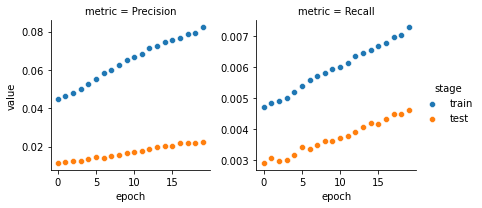

In [64]:
output3, _ = track_model_metrics(model=model, 
                                 train_interactions=train_interactions, 
                                 test_interactions=test_interactions, 
                                 k=K,
                                 no_epochs=20, 
                                 no_threads=4)

The next 2 models (with both implicit and explicit data) with different tuning parameters to compare

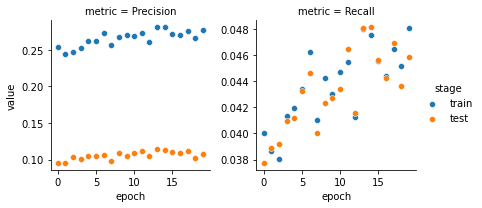

In [65]:
output2, _ = track_model_metrics(model=model2, 
                                 train_interactions=train_interactions2, 
                                 test_interactions=test_interactions2, 
                                 k=K,                              
                                 no_epochs=NO_EPOCHS, 
                                 no_threads=NO_THREADS, 
                                 item_features=item_features,
                                 user_features=user_features)

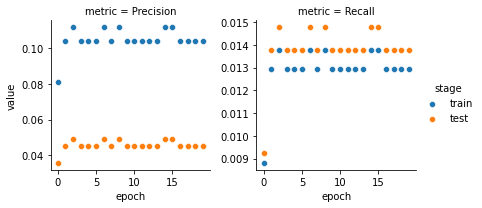

In [66]:
output4, _ = track_model_metrics(model=model4, 
                                 train_interactions=train_interactions2, 
                                 test_interactions=test_interactions2, 
                                 k=K,                              
                                 no_epochs=20, 
                                 no_threads=4, 
                                 item_features=item_features,
                                 user_features=user_features)

These show slightly different behaviour with the two approaches

### 4.1 Performance comparison

In addition, the model's performance metrics (based on the test dataset) can be plotted together to facilitate easier comparison as follows:

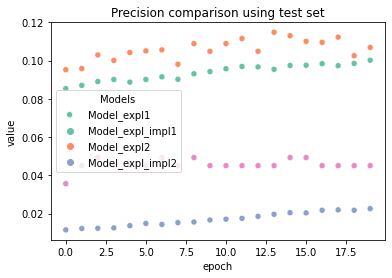

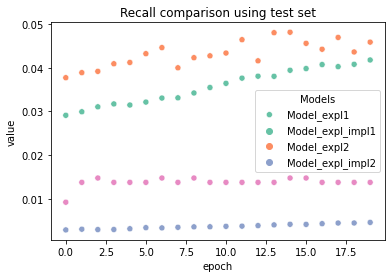

In [80]:
for i in ['Precision', 'Recall']:
    sns.set_palette("Set2")
    plt.figure()
    sns.scatterplot(x="epoch", 
                    y="value", 
                    hue='data',
                    data=compare_metric(df_list=[output1, output2, output3, output4], metric=i)
                   ).set_title(f'{i} comparison using test set')

    plt.legend(title='Models', labels=[model_labels[output] for output in ['output1', 'output2', 'output3', 'output4']])


Referring to the figures above, it is rather obvious that the number of epochs is too low as the model's performances have not stabilised

As stated previously, it is interesting to see model_expl_impl1 (using both implicit and explicit data,it's the orange dots in the graph,it is just the legend that is wrong ) performed consistently better than model2 (using only explicit ratings), and than all the rest of the models.

these are the best hyperparameters for this model


default number of recommendations
K = 10  
percentage of data used for testing
TEST_PERCENTAGE = 0.3  
model learning rate
LEARNING_RATE = 0.25  
no of latent factors
NO_COMPONENTS = 20  
no of epochs to fit model
NO_EPOCHS = 20  
no of threads to fit model
NO_THREADS = 4  
regularisation for both user and item features
ITEM_ALPHA = 1e-6  
USER_ALPHA = 1e-6  




## 5. Similar users and items

As the LightFM package operates based on latent embeddings, these can be retrieved once the model has been fitted to assess user-user and/or item-item affinity.

### 5.1 User affinity

The user-user affinity can be retrieved with the `get_user_representations` method from the fitted model as follows:

In [68]:
_, user_embeddings = model2.get_user_representations(features=user_features)
user_embeddings

array([[-2.9957767 , -0.10051303,  3.3634915 , ..., -4.3939257 ,
         1.6306299 ,  0.7340585 ],
       [-3.1835132 ,  2.546256  ,  3.9029095 , ..., -3.5946336 ,
         3.6931753 , -2.5886178 ],
       [-3.5630832 , -0.7697404 ,  5.040884  , ..., -5.3270264 ,
         0.3334377 ,  1.248422  ],
       ...,
       [-1.6015306 , -0.64789796,  2.4784408 , ..., -3.152396  ,
         4.988878  , -0.6224238 ],
       [-3.087742  ,  2.4682314 ,  3.7736108 , ..., -3.5050242 ,
         3.5825424 , -2.531286  ],
       [-3.2038589 ,  3.1508524 ,  3.2407074 , ..., -3.8836312 ,
         3.9077017 , -0.9429321 ]], dtype=float32)

In order to retrieve the top N similar users, we can use the `similar_users` from `recommenders`. For example, if we want to choose top 10 users most similar to the user 2:

In [69]:
UiD = 2

similar_users_df = similar_users(user_id=UiD, 
              user_features=user_features, 
              model=model2)

similar_users_df

,userID,score
0,445,0.999998
1,226,0.999997
2,329,0.999997
3,345,0.999996
4,461,0.999996
5,450,0.999995
6,636,0.999995
7,172,0.999994
8,394,0.999994
9,862,0.999994


We will then create an interaction matrix to find the top movies from these users

After we select the user the model finds the top N most similar users to him, and then identifies the highest-rated movie for each of those top N users based on the interactions_matrix. These movies are the most related movies according to those similar users.

In [70]:

# Assuming `data` is your DataFrame with columns 'userID', 'itemID', 'rating', and 'genre'

# Create the user-item interaction matrix
interactions_matrix = pd.pivot_table(data, index='userID', columns='itemID', values='rating', fill_value=0)

# Now `interaction_matrix` is a DataFrame where rows represent users, columns represent items,
# and the cells contain the ratings given by users to items.


# Suppose `interactions_matrix` is your user-item interaction matrix
# with rows representing users and columns representing items

# Get the top N similar user IDs using the similar_users function
similar_users_df = similar_users(user_id=UiD, user_features=user_features, model=model2)

# Extract the top N user IDs from the similar_users DataFrame
top_n_users = similar_users_df['userID'].tolist()

# Ensure top_n_users contains only user IDs present in interactions_matrix
top_n_users = interactions_matrix.index.intersection(top_n_users).tolist()

# Filter the interactions_matrix to extract interactions for the top N users
top_n_users_interactions = interactions_matrix.loc[top_n_users]

# Find the highest-rated movie for each user
top_n_users_highest_rated_movies = top_n_users_interactions.idxmax(axis=1)

# Now `top_n_users_highest_rated_movies` contains the highest-rated movie index for each of the top N users.


In [71]:
# Assuming you have already calculated top_n_users_highest_rated_movies
# and it is a pandas Series containing the highest-rated movie index for each user.

# Convert the movie index to movie ID (itemID) using the columns of interactions_matrix
top_n_users_highest_rated_movies = interactions_matrix.columns[top_n_users_highest_rated_movies]

# Create a DataFrame with the user IDs and their corresponding highest-rated movie IDs
result_df = pd.DataFrame({'userID': top_n_users, 'Top_movieID': top_n_users_highest_rated_movies})

# Get the similar users dataframe
similar_users_df = similar_users(user_id=UiD, user_features=user_features, model=model2)

# Merge the two dataframes on the 'userID' column
merged_topN_df = similar_users_df.merge(result_df, on='userID', how='left')

merged_topN_df

,userID,score,Top_movieID
0,445,0.999998,57
1,226,0.999997,10
2,329,0.999997,125
3,345,0.999996,13
4,461,0.999996,10
5,450,0.999995,12
6,636,0.999995,11
7,172,0.999994,184
8,394,0.999994,8
9,862,0.999994,8


In [72]:

# Merge the merged_topN_df with new_datax based on the connecting IDs 'Top_movieID' and 'itemID'
similar_users_df = merged_topN_df.merge(new_datax[['itemID', 'movie_name', 'genre']], 
                                        left_on='Top_movieID', 
                                        right_on='itemID', 
                                        how='left')[['userID', 'score', 'movie_name', 'genre']]

# Drop duplicate rows
similar_users_df = similar_users_df.drop_duplicates()

# Now the `similar_users_df` dataframe contains the user IDs, similarity scores, movie names, and genres
# for the top N similar users, where the movie information is merged from new_datax.

similar_users_df


,userID,score,movie_name,genre
0,445,0.999998,Priest (1994),Drama
40,226,0.999997,Richard III (1995),Drama|War
129,329,0.999997,Phenomenon (1996),Drama|Romance
373,345,0.999996,Mighty Aphrodite (1995),Comedy
557,461,0.999996,Richard III (1995),Drama|War
646,450,0.999995,"Usual Suspects, The (1995)",Crime|Thriller
913,636,0.999995,Seven (Se7en) (1995),Crime|Thriller
1149,172,0.999994,Army of Darkness (1993),Action|Adventure|Comedy|Horror|Sci-Fi
1265,394,0.999994,Babe (1995),Children's|Comedy|Drama
1484,862,0.999994,Babe (1995),Children's|Comedy|Drama


In [73]:
# Get the user ID
user_id = UiD

# Filter the DataFrame for movies watched by the user
user_movies_df = data[data['userID'] == user_id][['userID', 'itemID']]
user_movies_df = user_movies_df.merge(new_datax[['itemID', 'movie_name','genre']], on='itemID', how='left')
user_movies_df = user_movies_df.drop_duplicates()

user_movies_df



,userID,itemID,movie_name,genre
0,2,242,Kolya (1996),Comedy
117,2,302,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
414,2,257,Men in Black (1997),Action|Adventure|Comedy|Sci-Fi
717,2,274,Sabrina (1995),Comedy|Romance
907,2,1,Toy Story (1995),Animation|Children's|Comedy
...,...,...,...,...
12280,2,311,"Wings of the Dove, The (1997)",Drama|Romance|Thriller
12355,2,314,3 Ninjas: High Noon At Mega Mountain (1998),Action|Children's
12360,2,297,Ulee's Gold (1997),Drama
12410,2,19,Antonia's Line (1995),Drama


### 5.2 Item affinity

Similar to the user affinity, the item-item affinity can be retrieved with the `get_item_representations` method using the fitted model.

In [74]:
_, item_embeddings = model2.get_item_representations(features=item_features)
item_embeddings

array([[-0.72920704,  0.36348623,  0.61058277, ..., -0.6556344 ,
         0.43052635, -0.00740793],
       [-0.80648875,  0.3242817 ,  0.59262526, ..., -0.6599034 ,
         0.43475425, -0.03894316],
       [-0.7331916 ,  0.30415648,  0.60251135, ..., -0.70706546,
         0.38431227, -0.02209089],
       ...,
       [-0.0207727 ,  0.20716731,  0.15538666, ..., -0.32833546,
         0.19333282,  0.20605502],
       [-0.32075638,  0.64818287,  0.36617965, ..., -0.08507955,
        -0.14007023, -0.56448716],
       [-0.23034531,  0.07567144,  0.00682074, ..., -0.49054918,
        -0.11827411, -0.31578103]], dtype=float32)

The function to retrieve the top N similar items is similar to similar_users() above. For example, if we want to choose top 10 items most similar to the item 10:

In [75]:
item_id = 10  # Replace 10 with the desired item ID

# Get the movie name and genre for the specified item ID
movie_info = new_datax[new_datax['itemID'] == item_id][['movie_name', 'genre']].values[0]
movie_name = movie_info[0]
genre = movie_info[1]

print(f"Movie: {movie_name}")
print(f"Genre: {genre}\n")

# Get the similar items dataframe
similar_items(item_id=item_id, 
                                 item_features=item_features, 
                                 model=model2).merge(item_data[['itemID', 'movie_name']], 
                                                     left_on='itemID', 
                                                     right_on='itemID', 
                                                     how='left')[['itemID', 'score', 'movie_name']]



Movie: Richard III (1995)
Genre: Drama|War



,itemID,score,movie_name
0,350,0.999406,Fallen (1998)
1,150,0.999386,Swingers (1996)
2,1023,0.999345,Fathers' Day (1997)
3,900,0.999316,Kundun (1997)
4,523,0.999293,Cool Hand Luke (1967)
5,12,0.998668,"Usual Suspects, The (1995)"
6,231,0.998643,Batman Returns (1992)
7,182,0.998620,GoodFellas (1990)
8,474,0.998586,Dr. Strangelove or: How I Learned to Stop Worr...
9,253,0.998528,"Pillow Book, The (1995)"


In [76]:
#similar_items_df.to_csv('similar_items_df.csv', index=False)

In [77]:
item_id = 10  # Replace 10 with the desired item ID

# Get the movie name and genre for the specified item ID
movie_info = new_datax[new_datax['itemID'] == item_id][['movie_name', 'genre']].values[0]
movie_name = movie_info[0]
genre = movie_info[1]

print(f"Top 10 movies similar to: {movie_name}")
print(f"Genre: {genre}\n")

# Get the similar items dataframe
similar_items_df = similar_items(item_id=item_id, 
                                 item_features=item_features, 
                                 model=model2).merge(new_datax[['itemID', 'movie_name','genre']], 
                                                     left_on='itemID', 
                                                     right_on='itemID', 
                                                     how='left')[['itemID', 'score', 'movie_name','genre']]

# Drop duplicate rows
similar_items_df = similar_items_df.drop_duplicates()

similar_items_df




Top 10 movies similar to: Richard III (1995)
Genre: Drama|War



,itemID,score,movie_name,genre
0,350,0.999406,Fallen (1998),Action|Mystery|Thriller
41,150,0.999386,Swingers (1996),Comedy|Drama
198,1023,0.999345,Fathers' Day (1997),Comedy
229,900,0.999316,Kundun (1997),Drama
271,523,0.999293,Cool Hand Luke (1967),Comedy|Drama
435,12,0.998668,"Usual Suspects, The (1995)",Crime|Thriller
702,231,0.998643,Batman Returns (1992),Action|Adventure|Comedy|Crime
844,182,0.998620,GoodFellas (1990),Crime|Drama
1070,474,0.998586,Dr. Strangelove or: How I Learned to Stop Worr...,Sci-Fi|War
1264,253,0.998528,"Pillow Book, The (1995)",Drama|Romance


In [78]:
# Print the top 10 similar movies

similar_items_df = similar_items(item_id=item_id, 
                                 item_features=item_features, 
                                 model=model2).merge(item_data[['itemID', 'movie_name']], 
                                                     left_on='itemID', 
                                                     right_on='itemID', 
                                                     how='left')[['itemID', 'score', 'movie_name']]

top_10_movies = similar_items_df.head(10)['movie_name'].tolist()
print(f"Top 10 movies similar to {movie_name}:")
for movie in top_10_movies:
    print(movie)

Top 10 movies similar to Richard III (1995):
Fallen (1998)
Swingers (1996)
Fathers' Day (1997)
Kundun (1997)
Cool Hand Luke (1967)
Usual Suspects, The (1995)
Batman Returns (1992)
GoodFellas (1990)
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)
Pillow Book, The (1995)


In [79]:
# Record results for tests
sb.glue('eval_precision', eval_precision.tolist())
sb.glue('eval_recall', eval_recall.tolist())
sb.glue('eval_precision2', eval_precision2.tolist())
sb.glue('eval_recall2', eval_recall2.tolist())

## 6. Conclusion

In this notebook, the background of hybrid matrix factorisation model has been explained together with a detailed example of LightFM's implementation. 

The process of incorporating additional user and item metadata has also been demonstrated with performance comparison. Furthermore, the calculation of both user and item affinity scores have also been demonstrated and extracted from the fitted model.
